# Large Scale ESG Report Analysis

**By Tobias Schimanski and based on my paper: "Bridiging the Gap in ESG Measurement: Using NLP to Quantify Environmental, Social, and Governance Communication"**

This notebook serves as a basis for applying AI Natural Language Processing tools to corporate sustainability reports. It is particularily tailored for newcomers to the field with limited or no prior experience. In this tutorial, you can only press play and will be fine.

If you are already advanced, you might just [want to read the paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4622514) and or go directly to the [models on HuggingFace](https://huggingface.co/ESGBERT).

**In this tutorial, we learn how to use GPUs to facilitate large-scale analyses of multiple annual reports.**

This tutorial is the second of a series of tutorials. The first toutial [is here](https://medium.com/@schimanski.tobi/analyzing-esg-with-ai-and-nlp-tutorial-1-report-analysis-towards-esg-risks-and-opportunities-8daa2695f6c5).

## SET RUNTIME TO GPU

In order to use the models on large-scale, we want to use GPUs (processing units that are super fast). For this, we gut on "Runtime" underneath the tutorial name, choose "Change runtime type" and then select any "GPU", probably "T4 GPU" if you are not a premium user like me (no flex).

## Import libraries

We start by importing some standard libraries as well as the "transformers" one. This will help us to use the tools.

In [ ]:
!pip install transformers
!pip install tika

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline # for using the models

import spacy # for sentence extraction
from tika import parser # for the report extraction

/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0D991121-1B29-38E8-B953-7A27DA9FCC9B> /Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/andrew.mueller/y/envs/m

## Step 1: Load models

We are going to use models of the [ESG BERT project](https://huggingface.co/ESGBERT). In this tutorial, we use GPUs to speed up the process enourmously in comparison to Tutorial 1. For this tutroial, we want to detect environmental actions made by companies.

In [2]:
### Load the models (takes ca. 1 min)
# Environmental model.
name = "ESGBERT/EnvironmentalBERT-environmental" # path to download from HuggingFace
# In simple words, the tokenizer prepares the text for the model and the model classifies the text-
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name)
# The pipeline combines tokenizer and model to one process.
pipe_env = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0) # set device=0 to use GPU

# Action model.
name = "ESGBERT/EnvironmentalBERT-action"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name)
pipe_act = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0) # set device=0 to use GPU

### IMPORTANT: SET RUNTIME TO GPU (see above)

In [ ]:
# Tryout the model
pipe_env("We are really relying on people improving their consumer decisions to fight climate change.")

In [ ]:
pipe_act("We planted 7.500 trees in the last 5 years.")

## Step 2: Set up PDF extraction pipeline

We use the code from [Tutorial 1](https://medium.com/p/8daa2695f6c5) to set up a pipeline to transform PDF to texts.

In [3]:
# Encapsulate code from tutorial 1 in a function.
def PDFtoSentence(path):
  print(f"\nParsing {path}")
  # The from_file() function of tika helps us to load the content of the document. (take ca. 30 sec)
  print("- PDF to txt")
  report = parser.from_file(path)
  # For this, we use the nlp() function from spacy. (takes 20 secs)
  print("- txt to sentences")
  nlp = spacy.load('en_core_web_sm')
  about_doc = nlp(report["content"][:1000000])
  # One downside of spacy is that it can only parse 1.000.000 signs at a time.
  # You can write a for-loop around the report["content"] or use other tools.
  # For simplicitiy, we only use the first 1.000.000 characters.

  # We transfer the sequences ("about_doc.sents") to a list of raw strings.
  sequences = list(map(str, about_doc.sents))
  # "\n" signals a new line. We remove this so that the output looks better.
  sentences = [x.replace("\n", "") for x in sequences]
  # Remove all empty text, i.e. if the value is "", i.e are empty.
  sentences = [x for x in sentences if x != ""]
  # A sentence should start with upper case.
  sentences = [x for x in sentences if x[0].isupper()]
  return sentences

In [4]:
# Example reports.
audi22 = "https://www.audi.com/content/dam/gbp2/downloads/report/annual-reports/2022/en/audi-report-2022.pdf"
blackrock22 = "https://www.blackrock.com/us/individual/literature/annual-report/ar-retail-br-exchange-portfolio.pdf"
saudiaramco22 = "https://www.aramco.com/-/media/publications/corporate-reports/saudi-aramco-ara-2022-english.pdf?la=en&hash=6BC0409B50ECFF4A4C743307DF2FF7BDBCEC8B43"
telecom22 = "https://report.telekom.com/annual-report-2022/_assets/downloads/entire-dtag-ar22.pdf"
reports = [audi22, blackrock22, saudiaramco22, telecom22]

In [41]:
UDR_2023 = "https://www.responsibilityreports.com/HostedData/ResponsibilityReports/PDF/NYSE_UDR_2023.pdf"
UDR_2022 = "https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/u/NYSE_UDR_2022.pdf"
UDR_2021 = "https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/u/NYSE_UDR_2021.pdf"
UDR_reports = [UDR_2023, UDR_2022, UDR_2021]
# Create separate variables for each path in all_reports named by file name without .pdf extension
var_names = []
for file in files:
    var_name = os.path.splitext(file)[0]
    globals()[var_name] = os.path.join(directory_path, file)
    var_names.append(var_name)

# Create a list similar to UDR_reports
all_reports = [os.path.join(directory_path, file) for file in files]


In [30]:
import os

# Define the directory path
directory_path = "/Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/"

# Get a list of files and directories in the specified path
all_items = os.listdir(directory_path)

# Filter out only the files
files = [item for item in all_items if os.path.isfile(os.path.join(directory_path, item))]
# Print the list of files
print(directory_path,files)
print(all_items)

/Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/ ['VICI_2023.pdf', 'AIRC_2023.pdf', 'SHP_2023.pdf', 'UE_2022.pdf', 'WY_2022.pdf', 'KRC_2023.pdf', 'VTR_2022.pdf', 'BDN_2023.pdf', 'CPT_2023.pdf', 'EQC_2023.pdf', 'VTR_2023.pdf', 'SHO_2023.pdf', 'DRE_2022.pdf', 'VNO_2023.pdf', 'PK_2023.pdf', 'APLE_2023.pdf', 'VNO_2022.pdf', 'WELL_2022.pdf', 'DRH_2023.pdf', 'WELL_2021.pdf', 'COLD_2023.pdf', 'UMH_2023.pdf', 'AIV_2022.pdf', 'PCH_2022.pdf', 'CIO_2023.pdf', 'PEB_2023.pdf', 'SUI_2023.pdf', 'CDP_2023.pdf', 'RHP_2022.pdf', 'IIPR_2023.pdf', 'IRT_2023.pdf', 'NSA_2023.pdf', 'WSR_2023.pdf', 'NNN_2023.pdf', 'MAC_2022.pdf', 'AHH_2023.pdf']
['VICI_2023.pdf', 'AIRC_2023.pdf', 'SHP_2023.pdf', 'UE_2022.pdf', 'WY_2022.pdf', 'KRC_2023.pdf', 'VTR_2022.pdf', 'BDN_2023.pdf', 'CPT_2023.pdf', 'EQC_2023.pdf', 'VTR_2023.pdf', 'SHO_2023.pdf', 'DRE_2022.pdf', 'VNO_2023.pdf', 'PK_2023.pdf', 'APLE_2023.pdf', 'VNO_2022.pdf', 'WELL_20

In [26]:
reports = files
print(reports)

['VICI_2023.pdf', 'AIRC_2023.pdf', 'SHP_2023.pdf', 'UE_2022.pdf', 'WY_2022.pdf', 'KRC_2023.pdf', 'VTR_2022.pdf', 'BDN_2023.pdf', 'CPT_2023.pdf', 'EQC_2023.pdf', 'VTR_2023.pdf', 'SHO_2023.pdf', 'DRE_2022.pdf', 'VNO_2023.pdf', 'PK_2023.pdf', 'APLE_2023.pdf', 'VNO_2022.pdf', 'WELL_2022.pdf', 'DRH_2023.pdf', 'WELL_2021.pdf', 'COLD_2023.pdf', 'UMH_2023.pdf', 'AIV_2022.pdf', 'PCH_2022.pdf', 'CIO_2023.pdf', 'PEB_2023.pdf', 'SUI_2023.pdf', 'CDP_2023.pdf', 'RHP_2022.pdf', 'IIPR_2023.pdf', 'IRT_2023.pdf', 'NSA_2023.pdf', 'WSR_2023.pdf', 'NNN_2023.pdf', 'MAC_2022.pdf', 'AHH_2023.pdf']


In [5]:
# Run PDF to sentence.
audi22_sent = PDFtoSentence(audi22)

2024-10-29 01:57:19,849 [MainThread  ] [INFO ]  Retrieving https://www.audi.com/content/dam/gbp2/downloads/report/annual-reports/2022/en/audi-report-2022.pdf to /var/folders/41/ntzmfcsx5ms7vbngfv__6z540000gr/T/content-dam-gbp2-downloads-report-annual-reports-2022-en-audi-report-2022.pdf.



Parsing https://www.audi.com/content/dam/gbp2/downloads/report/annual-reports/2022/en/audi-report-2022.pdf
- PDF to txt
- txt to sentences


In [6]:
# Look at the sentences.
audi22_sent

['A year shaped by a difficult situation in the global econ-omy, sharply rising energy prices and continued supply shortages.',
 'A year in which we were so terribly caught off guard by the war in Ukraine, which has demanded our solidarity and cohesion more than anything else in recent memory.',
 'At the same time, as the team of the Premium brand group, we accomplished a lot together and generated a record operating profit¹ of EUR 7.6 billion thanks to the dedication and team spirit of all employees.',
 'The way we took on the challenges of the past year is an enormous achievement for which I would like to thank our more than 87,000 employees worldwide.',
 'The results show that, together, we are successfully guiding the Premium brand group with Audi, Bentley, Lamborghini and Ducati through turbu-lent times – always with our eyes on the horizon. ',
 'One milestone in 2023 will be the start of pro-duction of the Audi Q6 e-tron family in Ingolstadt on the flexible vehicle architecture o

# Step 3: Classify the sentences

Now, we want to find evironmental actions of each company. Thus, we develop a pipeline, where we first extract the sentences, then classify them. We only use the "action" model once a sentence was classified as environmental. The single steps are explained in [Tutorial 1](https://medium.com/p/8daa2695f6c5).

In [24]:
# Function that takes a report, peforms PDF to sentence and then classifies first "environmental", then "action" on the "environmental" sentences.
def classify(path, pipe_env, pipe_act):
  # Get sentences.
  print(f"\nSentence Extraction for {path}")
  sentences = PDFtoSentence(path)
  # Classify environmental.
  print(f"\nClassify environmental for {path}")
  # Batch size helps to handle the texts in parallel. If there are "out of memory" erros, decrease the batch size.
  classifications = pipe_env(sentences, padding=True, truncation=True, batch_size=16)
  # We only want the labels, so we take the first entry of the outputed dicts.
  labels_only = [x["label"] for x in classifications]
  # Create Dataframe with sentence and label
  df = pd.DataFrame({"text": sentences, "environmental": labels_only})

  # Take only environmental sentences and classify them.
  print(f"\nClassify action for {path}")
  df_env = df.loc[df["environmental"] == "environmental"].copy()
  # Batch size helps to handle the texts in parallel. If there are "out of memory" erros, decrease the batch size.
  classifications_act = pipe_act(df_env.text.to_list(), padding=True, truncation=True, batch_size=16)
  df_env["action"] = [x["label"] for x in classifications_act]

  # Combine action with all data.
  # Only take the "action" column of df_env to not have "text" and "environmental" duplicated.
  df_all = df.join(df_env[["action"]])

  return df_all

In [42]:
# Look at AUDI 22. (takes around a minute)
df_UE = classify(UE_2022,  pipe_env, pipe_act)


Sentence Extraction for /Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/UE_2022.pdf

Parsing /Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/UE_2022.pdf
- PDF to txt
- txt to sentences

Classify environmental for /Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/UE_2022.pdf

Classify action for /Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/UE_2022.pdf


In [43]:
# Have a look at the results.
df_UE[df_UE["environmental"] == "environmental"]

,text,environmental,action
0,Our ESG Policy Commitment10 United Nations Sus...,environmental,none
1,"Our Social Strategy32 Our People 33 Diversity,...",environmental,none
5,The resilience of the shopping center industry...,environmental,action
7,We are proud to have implemented green lease l...,environmental,action
8,Our collaborative efforts led to Urban Edge re...,environmental,action
...,...,...,...
828,Report pages 20-27c) Describe how processes fo...,environmental,none
829,Report pages 20-27Metrics and TargetsDisclose ...,environmental,none
830,"Report pages 5, 8, 15-18, 26, 28-29b) Disclose...",environmental,none
831,"Report pages 24-26, 29, and GRI 305-1 and 305-...",environmental,none


In [17]:
# How sentences are about environment?
env_pct = df_audi[df_audi["environmental"] == "environmental"].shape[0] / df_audi.shape[0]
print(f"{env_pct:.2f} of the sentences are addressing environmental topics.")
# How many sentences are about environmental action?
envact_pct = df_audi[df_audi["action"] == "action"].shape[0] / df_audi.shape[0]
print(f"{envact_pct:.2f} of the sentences are addressing environmental actions.")

0.27 of the sentences are addressing environmental topics.
0.08 of the sentences are addressing environmental actions.


# Step 4: Analyse all reports

Finally, we want to analyse all 5 reports and compare the companies. You can press "play" on the following code. It will run for about five minutes. So take a coffee in the meantime.

In [44]:
# Run all reports (takes around 5 min).
# Store environmental and environmental action percentages.
env_pcts, envact_pcts, dfs = [], [], []
#for rep in reports:
for rep in var_names:
  df = classify(rep, pipe_env, pipe_act)
  df["path"] = rep
  # Calculate and store pcts.
  env_pct = df[df["environmental"] == "environmental"].shape[0] / df.shape[0]
  envact_pct = df[df["action"] == "action"].shape[0] / df.shape[0]
  env_pcts.append(env_pct)
  envact_pcts.append(envact_pct)
  # Store all outputs in the dfs list.
  dfs.append(df)


Sentence Extraction for VICI_2023

Parsing VICI_2023
- PDF to txt


FileNotFoundError: [Errno 2] No such file or directory: '/Users/andrew.mueller/Documents/VSCode/esg-forked/VICI_2023'

In [36]:
# Run all reports (takes around 5 min).
# Store environmental and environmental action percentages.
env_pcts, envact_pcts, dfs = [], [], []
for rep in UDR_reports:
  df = classify(rep, pipe_env, pipe_act)
  df["path"] = rep
  # Calculate and store pcts.
  env_pct = df[df["environmental"] == "environmental"].shape[0] / df.shape[0]
  envact_pct = df[df["action"] == "action"].shape[0] / df.shape[0]
  env_pcts.append(env_pct)
  envact_pcts.append(envact_pct)
  # Store all outputs in the dfs list.
  dfs.append(df)

2024-10-29 03:07:15,673 [MainThread  ] [INFO ]  Retrieving https://www.responsibilityreports.com/HostedData/ResponsibilityReports/PDF/NYSE_UDR_2023.pdf to /var/folders/41/ntzmfcsx5ms7vbngfv__6z540000gr/T/hosteddata-responsibilityreports-pdf-nyse_udr_2023.pdf.



Sentence Extraction for https://www.responsibilityreports.com/HostedData/ResponsibilityReports/PDF/NYSE_UDR_2023.pdf

Parsing https://www.responsibilityreports.com/HostedData/ResponsibilityReports/PDF/NYSE_UDR_2023.pdf
- PDF to txt
- txt to sentences

Classify environmental for https://www.responsibilityreports.com/HostedData/ResponsibilityReports/PDF/NYSE_UDR_2023.pdf

Classify action for https://www.responsibilityreports.com/HostedData/ResponsibilityReports/PDF/NYSE_UDR_2023.pdf


2024-10-29 03:07:29,848 [MainThread  ] [INFO ]  Retrieving https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/u/NYSE_UDR_2022.pdf to /var/folders/41/ntzmfcsx5ms7vbngfv__6z540000gr/T/hosteddata-responsibilityreportarchive-u-nyse_udr_2022.pdf.



Sentence Extraction for https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/u/NYSE_UDR_2022.pdf

Parsing https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/u/NYSE_UDR_2022.pdf
- PDF to txt
- txt to sentences

Classify environmental for https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/u/NYSE_UDR_2022.pdf


KeyboardInterrupt: 

Now, we plot the results. Actually, I use ChatGPT to just ask how I could plot these values (with matplotlib).

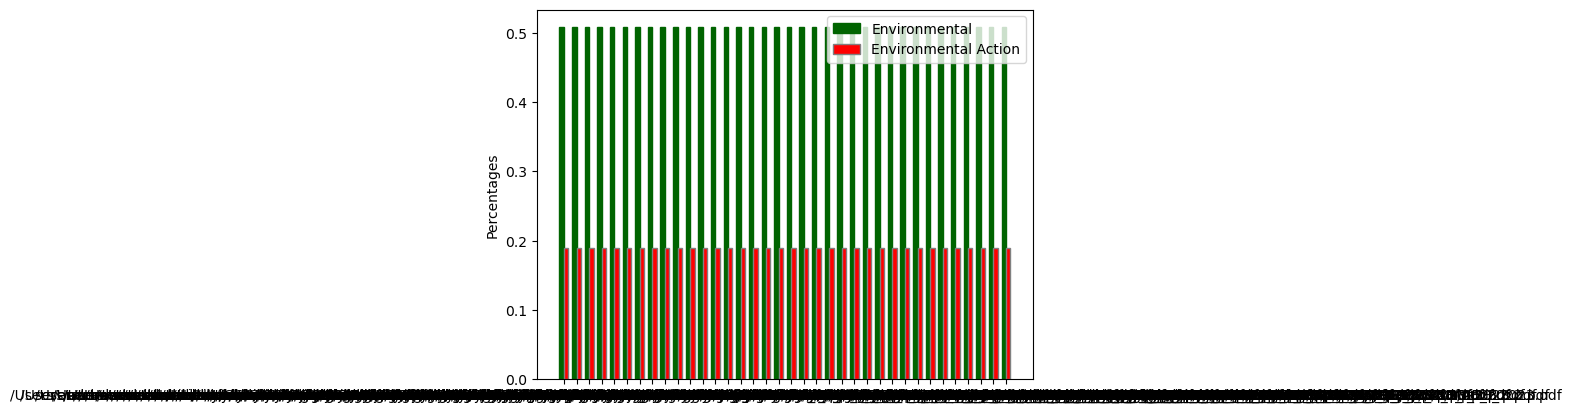

In [39]:
# Visualize the ratios for the companies.
# Sample data
categories = ['UDR_2023', 'UDR_2022', 'UDR_2021']
categories = all_reports
#categories = ['Audi22', 'BlackRock', 'Aramco', 'Telekom']
values1 = env_pcts
values2 = envact_pcts

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]

# Create the grouped bar plot
plt.bar(r1, values1, color='darkgreen', width=bar_width, edgecolor='darkgreen', label='Environmental')
plt.bar(r2, values2, color='red', width=bar_width, edgecolor='grey', label='Environmental Action')

# Add labels, title, and legend
#plt.xlabel('Nature categories')
plt.ylabel('Percentages')
plt.xticks([r + bar_width/2 for r in range(len(categories))], categories)
#plt.title('Grouped Bar Plot')
plt.legend()

# Show the plot
plt.show()

Interesting. I'll leave you to interpret this. Keep in mind: The BlackRock Annual Report is not of the whole company but it's exchange portfolio.

# Caveat

If you take a closer look at the results then you might find that some sentences are not actually environmental or action. This may lie in biases or shortcomings in the training data. No system is perfect. Particularily, the "action" dataset only contains 500 entries. Thus, fine-tuning your own models with extensions of the datasets might be a good strategy. Since I [open-source all datasets](https://huggingface.co/ESGBERT) on HuggingFace, you can use mine as a basis for further extensions.

I will address fine-tuning of models in the next tutorial. It's actually quite straightforward. Until then, feel free to read the [paper on the ESG BERTs](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4622514) or follow [me on LinkedIn](https://www.linkedin.com/in/tobias-schimanski-964077182/) to not miss out on new developments.

Second Tutorial is [here](https://medium.com/@schimanski.tobi/analyzing-esg-with-ai-and-nlp-tutorial-2-large-scale-analyses-of-environmental-actions-0735cc8dc9c2).